In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('../data/titanic/train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
df.sample(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
204,205,1,3,"Cohen, Mr. Gurshon ""Gus""",male,18.0,0,0,A/5 3540,8.0500,NaN,S
797,798,1,3,"Osman, Mrs. Mara",female,31.0,0,0,349244,8.6833,NaN,S


In [5]:
def clean(df):
    df['Cabin'] = df.Cabin.str.slice(0, 1)
    df = pd.get_dummies(df, dummy_na=True, columns=['Cabin', 'Embarked', 'Pclass'])
    
    df['AgeNull'] = df.Age.isna()
    df.Age.fillna(0, inplace=True)
    
    df.drop(columns='PassengerId Name Ticket'.split(), inplace=True)
    df['Sex'] = df.Sex == 'male'
    
    return df

In [6]:
cleaned = clean(df.copy())

In [7]:
from sklearn.model_selection import train_test_split

# we make our test set
X_train, X_test, y_train, y_test = train_test_split(cleaned.drop(columns='Survived'), cleaned.Survived, test_size=0.2)

# and we make our validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

In [9]:
# looks like cols 1, 2, 
cleaned.drop(columns='Survived').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
Sex             891 non-null bool
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Fare            891 non-null float64
Cabin_A         891 non-null uint8
Cabin_B         891 non-null uint8
Cabin_C         891 non-null uint8
Cabin_D         891 non-null uint8
Cabin_E         891 non-null uint8
Cabin_F         891 non-null uint8
Cabin_G         891 non-null uint8
Cabin_T         891 non-null uint8
Cabin_nan       891 non-null uint8
Embarked_C      891 non-null uint8
Embarked_Q      891 non-null uint8
Embarked_S      891 non-null uint8
Embarked_nan    891 non-null uint8
Pclass_1.0      891 non-null uint8
Pclass_2.0      891 non-null uint8
Pclass_3.0      891 non-null uint8
Pclass_nan      891 non-null uint8
AgeNull         891 non-null bool
dtypes: bool(2), float64(2), int64(2), uint8(17)
memory usage: 44.5 KB


In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

In [15]:
def feature_preprocess(X, y, skb=None, ss=None):
    if ss is None:
        ss = StandardScaler()
        ss.fit(X)
        
    X = ss.transform(X)
    
    if skb is None:
        skb = SelectKBest(mutual_info_classif, k=10)
        skb.fit(X, y)
        
    X = skb.transform(X)
        
    return X, y, skb, ss

In [58]:
X_proc_train, y_proc_train, skb, ss = feature_preprocess(X_train, y_train)

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
lr = LogisticRegression()

lr.fit(X_proc, y_proc)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
lr.score(X_proc, y_proc)

0.7978910369068541

In [20]:
X_proc, y_proc, skb, ss = feature_preprocess(X_val, y_val, skb, ss)

In [21]:
lr.score(X_proc, y_proc)

0.7482517482517482

In [57]:
from sklearn.dummy import DummyClassifier

In [60]:
dc = DummyClassifier()
dc.fit(X_proc_train, y_proc_train)

dc.score(X_proc, y_proc)

0.45454545454545453

In [22]:
from sklearn.metrics import confusion_matrix

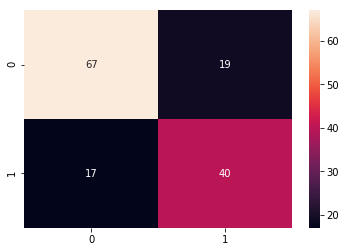

In [23]:
sns.heatmap(confusion_matrix(y_proc, lr.predict(X_proc)), annot=True)

In [24]:
from sklearn.metrics import classification_report

In [67]:
print(classification_report(y_proc, lr.predict_proba(X_proc)[:, 1] > .05)) 

             precision    recall  f1-score   support

          0       1.00      0.02      0.05        86
          1       0.40      1.00      0.58        57

avg / total       0.76      0.41      0.26       143



In [25]:
print(classification_report(y_proc, lr.predict(X_proc)))

             precision    recall  f1-score   support

          0       0.80      0.78      0.79        86
          1       0.68      0.70      0.69        57

avg / total       0.75      0.75      0.75       143



In [26]:
y_test = y_proc
y_score = lr.decision_function(X_proc)

In [27]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.84')

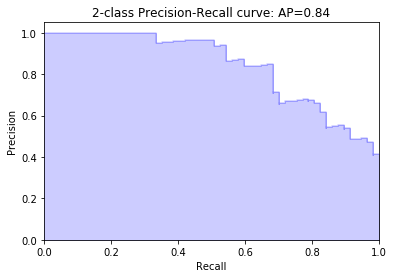

In [28]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, threshold = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [29]:
# let's look at the coefs from the logistic regression
lr.coef_

array([[-1.30209484, -0.18753707,  0.06962827, -0.25667838,  0.05110391,
        -0.41702876,  0.12088778,  0.21584945,  0.13769621, -0.29702945]])

In [33]:
# these are the columns for the above coefs
cleaned.drop(columns='Survived').columns[skb.get_support()]

Index(['Sex', 'Parch', 'Fare', 'Cabin_C', 'Cabin_D', 'Cabin_nan', 'Embarked_C',
       'Pclass_1.0', 'Pclass_2.0', 'Pclass_3.0'],
      dtype='object')

let's look specifically at the sex column

In [36]:
import numpy as np

# remember that we need to do an exponential transform to see how an increase of 1 will change our odds of survival
# but there is a problem with just taking the exp, remember we scaled it!
np.exp(lr.coef_)

array([[0.27196148, 0.82899839, 1.07210957, 0.77361698, 1.05243225,
        0.65900197, 1.12849826, 1.24091555, 1.14762685, 0.74302213]])

In [69]:
# so first we need to divide by the std that we transformed them with
# now we no that for each 1 increase we will multiply the log odds pred by...
np.exp(lr.coef_ / ss.scale_[skb.get_support()])

array([[0.06580164, 0.8274961 , 1.08864071, 0.99454014, 1.50620267,
        0.3673159 , 1.36565103, 1.62233565, 1.38692031, 0.55030727]])